<a href="https://colab.research.google.com/github/ccarpenterg/introNLP/blob/master/03a_NLP_and_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP and Recurrent Neural Networks

In [0]:
!pip install -q tensorflow-datasets==1.3.2

In [2]:
# load Tensorflow 2
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow import keras

import tensorflow_datasets as tfds
import numpy as np

print("Tensorflow version:", tf.__version__)
print("Tensorflow datasets version:", tfds.__version__)

TensorFlow 2.x selected.
Tensorflow version: 2.1.0
Tensorflow datasets version: 1.3.2


## Sentiment Analysis of IMDB Movie Reviews

In [0]:
train_validation_split = tfds.Split.TRAIN.subsplit([8, 2])

(train_validation_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (train_validation_split, tfds.Split.TEST),
    as_supervised=True,
    with_info=True
)

train_data, validation_data = train_validation_data

In [0]:
encoder = info.features['text'].encoder

## Preprocessing the Dataset with Padding

In [0]:
BUFFER_SIZE = 5000
BATCH_SIZE = 32

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_data))
)

validation_batches = (
    validation_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(validation_data))
)

test_batches = (
    test_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))
)

In [6]:
for batch_example, labels in train_batches.take(2):
    print("Batch shape:", batch_example.shape)
    print("Labels shape:", labels.shape)

Batch shape: (32, 915)
Labels shape: (32,)
Batch shape: (32, 1008)
Labels shape: (32,)


## Sequence Processing with a Recurrent Neural Network

### Model 1: SubWord Embedding, 1 LSTM layer, 1 FC layer

In [7]:
model_v1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 561,089
Trainable params: 561,089
Non-trainable params: 0
_________________________________________________________________


### Model 2: SubWord Embedding, 1 Bidirectional LSTM layer, 1 FC layer

In [8]:
model_v2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


**Embeding layer**



**LSTM layer**

Cell: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Update gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Forget gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Output gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

**Bidirectional**

Forward LSTM: 33,024 parameters

Backward LSTM: 33,024 parameters

Total: 66,048 parameters

**FC layer**

The bidirectional layer outputs two activationn vectors, one for the forward LSTM and one for the backward LTSM, that gives us 128 activation units.

64 * 128 weigths + 64 biases = 8,256 parameters

**Dense classifier layer**

1 * 64 weights + 1 bias = 64 parameters

### Model 3: SubWord Embedding, 2 Bidirectional LSTM layers, 1 FC layer

In [9]:
model_v3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 697,025
Trainable params: 697,025
Non-trainable params: 0
_________________________________________________________________


### Model 4: SubWord Embedding, 2 Bidirectional LSTM layers, 1 Global Average Poling (hidden states), 1 FC layer

In [10]:
model_v4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 688,833
Trainable params: 688,833
Non-trainable params: 0
_________________________________________________________________


## Training the RNNs on the IMDB Reviews Dataset

In [0]:
EPOCHS = 10
VAL_STEPS = 30
results = {}

In [12]:
model_v1.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=['accuracy'])

results['v1'] = model_v1.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 42s 68ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.5115
Epoch 2/10
625/625 [==============================] - 34s 54ms/step - loss: 0.6929 - accuracy: 0.5056 - val_loss: 0.6933 - val_accuracy: 0.5115
Epoch 3/10
625/625 [==============================] - 34s 55ms/step - loss: 0.6928 - accuracy: 0.5034 - val_loss: 0.6943 - val_accuracy: 0.4865
Epoch 4/10
625/625 [==============================] - 34s 54ms/step - loss: 0.6914 - accuracy: 0.5088 - val_loss: 0.6943 - val_accuracy: 0.4854
Epoch 5/10
625/625 [==============================] - 34s 55ms/step - loss: 0.6898 - accuracy: 0.5121 - val_loss: 0.6930 - val_accuracy: 0.4896
Epoch 6/10
625/625 [==============================] - 34s 55ms/step - loss: 0.6871 - accuracy: 0.5125 - val_loss: 0.6941 - val_accuracy: 0.4938
Epoch 7/10
625/625 [==============================] - 34s 55ms/step - loss: 0.6854 - accuracy: 0.5178 - val_loss: 0.6929 - val_accuracy:

In [13]:
test_loss, test_accuracy = model_v1.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.6891314504701463
Test Accuracy: 0.5073599815368652


In [14]:
model_v2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

results['v2'] = model_v2.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 59s 94ms/step - loss: 0.6360 - accuracy: 0.6124 - val_loss: 0.4248 - val_accuracy: 0.8052
Epoch 2/10
625/625 [==============================] - 56s 90ms/step - loss: 0.3351 - accuracy: 0.8626 - val_loss: 0.3108 - val_accuracy: 0.8760
Epoch 3/10
625/625 [==============================] - 57s 91ms/step - loss: 0.2459 - accuracy: 0.9092 - val_loss: 0.2845 - val_accuracy: 0.8781
Epoch 4/10
625/625 [==============================] - 57s 91ms/step - loss: 0.2065 - accuracy: 0.9276 - val_loss: 0.3043 - val_accuracy: 0.8656
Epoch 5/10
625/625 [==============================] - 58s 92ms/step - loss: 0.1705 - accuracy: 0.9420 - val_loss: 0.3252 - val_accuracy: 0.8729
Epoch 6/10
625/625 [==============================] - 58s 92ms/step - loss: 0.1520 - accuracy: 0.9490 - val_loss: 0.3315 - val_accuracy: 0.8844
Epoch 7/10
625/625 [==============================] - 58s 92ms/step - loss: 0.1296 - accuracy: 0.9577 - val_loss: 0.3590 - val_accuracy:

In [15]:
test_loss, test_accuracy = model_v2.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.5328322654909186
Test Accuracy: 0.8501999974250793


In [16]:
model_v3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

results['v3'] = model_v3.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 107s 171ms/step - loss: 0.5828 - accuracy: 0.6665 - val_loss: 0.3877 - val_accuracy: 0.8417
Epoch 2/10
625/625 [==============================] - 102s 163ms/step - loss: 0.3193 - accuracy: 0.8708 - val_loss: 0.2997 - val_accuracy: 0.8760
Epoch 3/10
625/625 [==============================] - 103s 164ms/step - loss: 0.2299 - accuracy: 0.9151 - val_loss: 0.2923 - val_accuracy: 0.8979
Epoch 4/10
625/625 [==============================] - 102s 164ms/step - loss: 0.1850 - accuracy: 0.9362 - val_loss: 0.3041 - val_accuracy: 0.8906
Epoch 5/10
625/625 [==============================] - 103s 166ms/step - loss: 0.1492 - accuracy: 0.9530 - val_loss: 0.3691 - val_accuracy: 0.8708
Epoch 6/10
625/625 [==============================] - 104s 166ms/step - loss: 0.1216 - accuracy: 0.9616 - val_loss: 0.3827 - val_accuracy: 0.8760
Epoch 7/10
625/625 [==============================] - 104s 167ms/step - loss: 0.0983 - accuracy: 0.9733 - val_loss: 0.3770 -

In [17]:
test_loss, test_accuracy = model_v3.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.572057230843474
Test Accuracy: 0.8482000231742859


In [18]:
model_v4.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=['accuracy'])

results['v4'] = model_v4.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 107s 171ms/step - loss: 0.6610 - accuracy: 0.5785 - val_loss: 0.4711 - val_accuracy: 0.8000
Epoch 2/10
625/625 [==============================] - 102s 164ms/step - loss: 0.4187 - accuracy: 0.8321 - val_loss: 0.3813 - val_accuracy: 0.8531
Epoch 3/10
625/625 [==============================] - 103s 165ms/step - loss: 0.3868 - accuracy: 0.8442 - val_loss: 0.3659 - val_accuracy: 0.8510
Epoch 4/10
625/625 [==============================] - 103s 165ms/step - loss: 0.2889 - accuracy: 0.8962 - val_loss: 0.3272 - val_accuracy: 0.8792
Epoch 5/10
625/625 [==============================] - 103s 165ms/step - loss: 0.2523 - accuracy: 0.9112 - val_loss: 0.3251 - val_accuracy: 0.8823
Epoch 6/10
625/625 [==============================] - 104s 167ms/step - loss: 0.3932 - accuracy: 0.8708 - val_loss: 0.4819 - val_accuracy: 0.7990
Epoch 7/10
625/625 [==============================] - 103s 165ms/step - loss: 0.2868 - accuracy: 0.8977 - val_loss: 0.4171 -

In [19]:
test_loss, test_accuracy = model_v4.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.392453764424757
Test Accuracy: 0.8565599918365479


In [0]:
import matplotlib.pyplot as plt

def plot_metrics(training_results):

    training_dict = training_results.history

    acc = training_dict['accuracy']
    val_acc = training_dict['val_accuracy']
    loss = training_dict['loss']
    val_loss = training_dict['val_loss']

    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

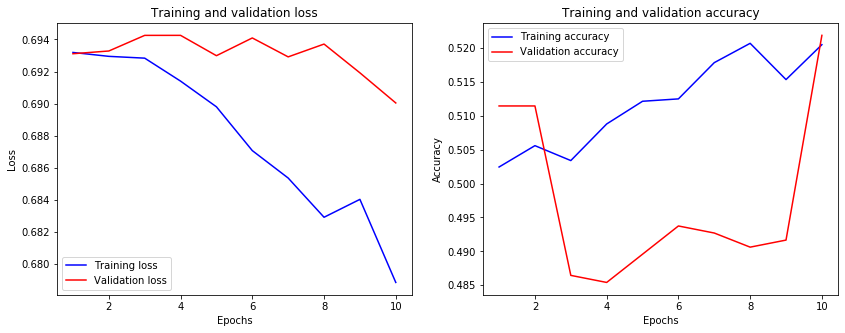

In [21]:
plot_metrics(results['v1'])

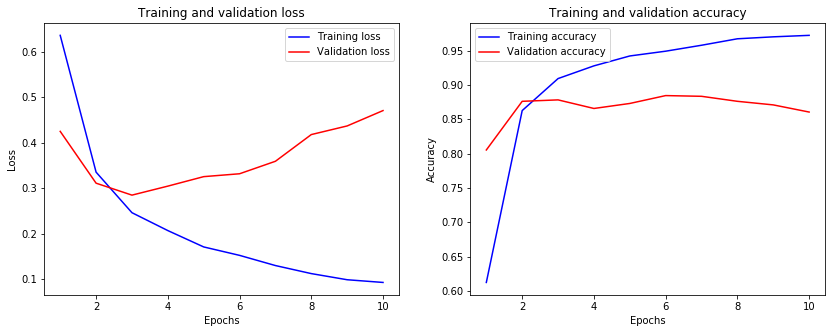

In [22]:
plot_metrics(results['v2'])

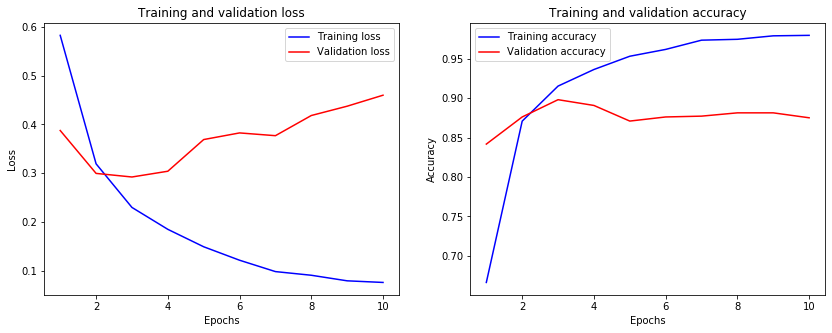

In [23]:
plot_metrics(results['v3'])

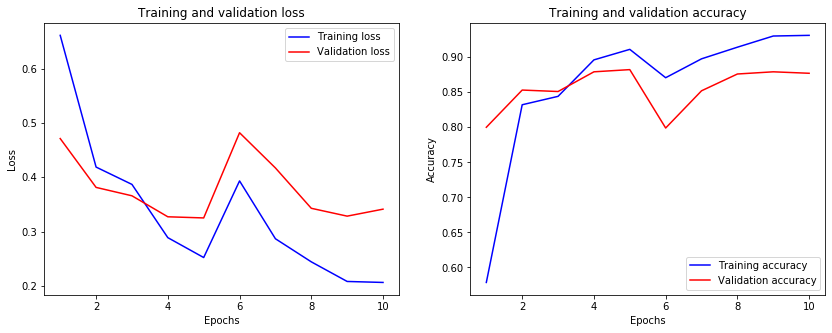

In [24]:
plot_metrics(results['v4'])